In [1]:
# additional in vitro bulk RNA-seq data from Matthias, received by email from Matthias Friedrich

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize as cnorm

import seaborn as sns

In [2]:
# Load vst-normalised RNA-seq matrix
vst_mat = pd.read_csv('bulkRNA_DE_batch2/filtered_vst_RNAseq_invitromodel.csv')
vst_mat

Unnamed: 0  1_unstim_none  10_Combo_none  11_Combo_none  12_Combo_none  \
0           A1BG     152.717089      96.274719     115.310124     111.484677   
1       A1BG-AS1     169.000000     120.691885     170.422670     133.561580   
2           A1CF       0.000000       1.000000       2.000000       0.000000   
3            A2M    3969.989066    2492.000000    4448.986941    4207.000000   
4        A2M-AS1      18.000000      11.000000      16.000000      19.000000   
...          ...            ...            ...            ...            ...   
28355     ZYG11A       6.165007       8.308491      15.649522      17.629928   
28356     ZYG11B    1506.734963    1345.859033    1579.436749    1494.742180   
28357        ZYX    5344.000000    3626.000000    4649.000000    5091.000000   
28358      ZZEF1    1828.770731    1628.498505    1955.631114    1868.768692   
28359       ZZZ3    1049.072481     967.721540    1186.391588    1127.489087   

       13_Combo_DMSO  14_Combo_DMSO  15_Combo_DMSO  16_Combo_DMSO  \
0         120.408644     121.154733      99.264366     136.746659   
1         153.000000     139.357441     150.070080     154.014573   
2           1.000000       0.000000       2.000000       1.032175   
3        5233.000000    4045.000000    4564.986403    3610.000000   
4          26.000000      23.000000      29.000000      13.000000   
...              ...            ...            ...            ...   
28355       0.074501       0.000000      12.603065      16.225552   
28356    1653.349505    1694.242623    1711.978115    1559.151825   
28357    5085.000000    5188.000000    5344.000000    5097.000000   
28358    1902.919709    2041.865409    1956.089949    1906.720904   
28359    1212.321914    1285.231799    1289.234632    1138.284546   

       17_Combo_Belinostat  ...  22_Combo_GSKJ4  23_Combo_GSKJ4  \
0               110.601488  ...       90.896963       99.833335   
1               166.349666  ...      139.019265      155.082234   
2                 1.000322  ...        0.000000        1.000039   
3               926.991623  ...     9819.882801     7735.000000   
4                13.000000  ...       15.000000       11.000000   
...                    ...  ...             ...             ...   
28355            23.271981  ...       12.459651       13.182532   
28356          1742.259538  ...     1502.470699     1409.614015   
28357          3533.000000  ...     5992.000000     5675.000000   
28358          2034.706262  ...     1790.953446     1705.987322   
28359          1193.152213  ...     1143.294040     1174.749610   

       24_Combo_GSKJ4  3_unstim_none  4_unstim_none  5_17uT_none  6_17uT_none  \
0          117.237193     122.779722     114.510628   127.066757   128.739770   
1          140.999400     182.105534     144.017873   148.096559   131.270886   
2            0.000000       0.000000       1.000000     1.000000     4.000000   
3         6937.000000    7262.993277    5354.983039  5330.848713  5190.985473   
4            9.000000      27.000000      27.000000    33.000000    25.000000   
...               ...            ...            ...          ...          ...   
28355        0.000000       7.185752       8.389756     8.572070     4.134592   
28356     1445.143326    1749.508950    1644.055058  1455.387942  1506.248922   
28357     5347.000000    5471.000000    5846.000000  4972.000000  5277.000000   
28358     1704.897333    2332.411732    1959.038044  1771.247814  1804.124350   
28359     1041.252218    1297.207294    1103.442702  1067.373949  1153.730119   

       7_17uT_none  8_17uT_none  9_Combo_none  
0       131.832075   137.573872    116.784103  
1       146.586612   149.162771    147.018376  
2         0.000000     1.017164      0.000000  
3      5107.000000  7267.887411   6430.984886  
4        19.000000    16.000000     11.000000  
...            ...          ...           ...  
28355    18.320190    20.282164      9.529191  
28356  1384.211446  1676.443285   1383.185942  
28357 

In [3]:
np.log2(2)

1.0

In [4]:
# Parses DESeq differential expression table returning rows with significant genes
def load_de_genes(fn, sep=',', max_p=0.01, min_lfc=2, max_n=1000):
    de_df = pd.read_csv(fn, sep=sep, index_col=0)
    de_df = de_df.where(lambda x: (x.padj < max_p) & (x.log2FoldChange > min_lfc)).dropna().sort_values(['padj', 'log2FoldChange'], ascending=[True, False])
    return de_df.iloc[0:max_n, :]

def load_de_genes_down(fn, sep=',', max_p=0.01, max_lfc=-2, max_n=1000):
    de_df = pd.read_csv(fn, sep=sep, index_col=0)
    de_df = de_df.where(lambda x: (x.padj < max_p) & (x.log2FoldChange < max_lfc)).dropna().sort_values(['padj', 'log2FoldChange'], ascending=[True, False])
    return de_df.iloc[0:max_n, :]

In [5]:
# # Load DESeq2 differential expression statistics
conditions = [
    '17uT_over_unstim',
    'Belinostat_over_DMSO',
    'Belinostat_over_unstim',
    'Combo_over_unstim',
    'GSKJ4_over_DMSO']

In [6]:
# Read tables, store in dictionary
de_tabs_all = {
    key: pd.read_csv("bulkRNA_DE_batch2/P0.05_filtered_RNAseq_invitromodel_" + key + ".csv", index_col=0) for key in conditions
}

In [7]:
import matplotlib.pylab as plt
from adjustText import adjust_text

In [9]:
#df

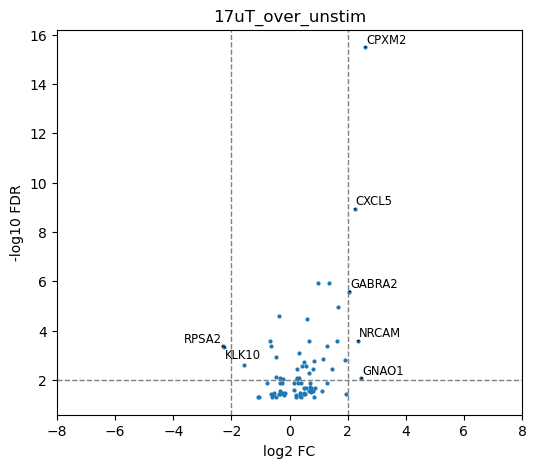

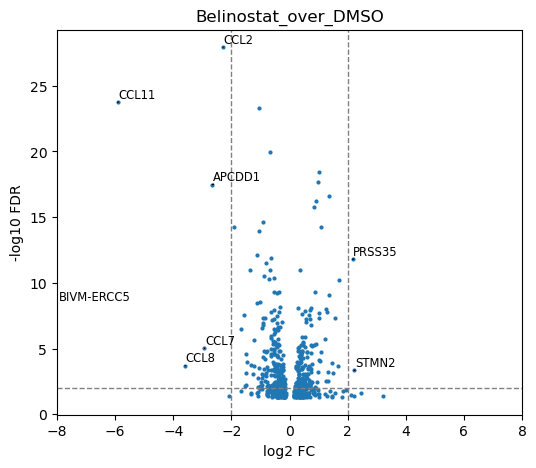

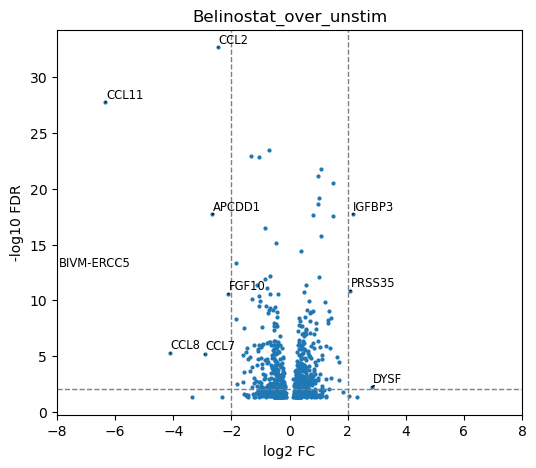

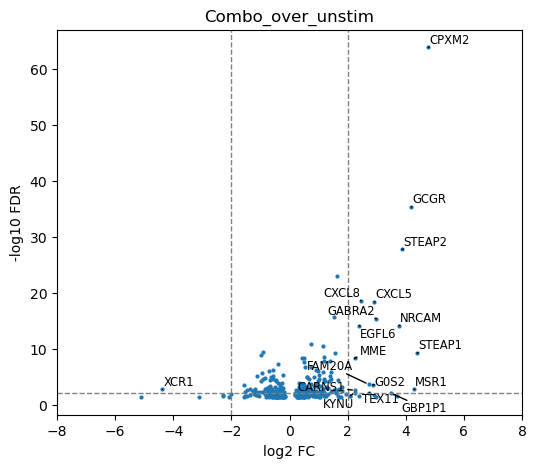

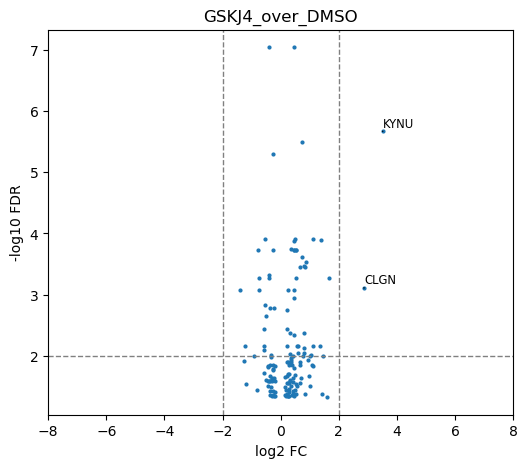

In [10]:
sk.set_figsize((6, 5))

#fig, axs = plt.subplots(len(conditions))

for key in conditions:
    
    # volcano plot
    #df = de_tabs_all['Combo_over_unstim']
    df = de_tabs_all[key]
    plt.scatter(
        x=df['log2FoldChange'],
        y=df['padj'].apply(lambda x:-np.log10(x)),
        s=4,  # point size
    )
    
    plt.xlim([-8, 8])

    sig = df[(np.abs(df.log2FoldChange) > 2) & (df.padj < 0.01)]

    texts=[]
    for index,row in sig.iterrows():
        texts.append(
            plt.text(
                x=row.log2FoldChange,
                y=-np.log10(row.padj),
                s=index,  # gene string
                size='small')
        )

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color='black', lw=1.0)
    )

    plt.xlabel("log2 FC")
    plt.ylabel("-log10 FDR")
    plt.title(key)
    plt.axvline(-2, color="grey", linestyle="--", lw=1.0)
    plt.axvline(2, color="grey", linestyle="--", lw=1.0)
    plt.axhline(2, color="grey", linestyle="--", lw=1.0)
    
    plt.savefig("figures/volcano/volcano_" + key + ".pdf")
    plt.show()


In [11]:
# Load gene tables of differentially up-regulated genes
de_tabs_sig = {
    key: load_de_genes("bulkRNA_DE_batch2/P0.05_filtered_RNAseq_invitromodel_" + key + ".csv", min_lfc=0.0) for key in conditions
}

In [12]:
# Count number of significant genes
[de_tabs_sig[key].shape[0] for key in de_tabs_sig]

[26, 164, 265, 110, 42]

In [13]:
de_tabs_sig_down = {
    key: load_de_genes_down("bulkRNA_DE_batch2/P0.05_filtered_RNAseq_invitromodel_" + key + ".csv", max_lfc=0.0) for key in conditions
}

In [14]:
[de_tabs_sig_down[key].shape[0] for key in de_tabs_sig_down]

[10, 192, 245, 75, 19]

In [15]:
de_tabs_sig_down['Belinostat_over_DMSO'].head(10)

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
CCL2       1143.665937       -2.288047  0.191736 -11.933306  7.935758e-33   
CCL11       210.602830       -5.909838  0.535332 -11.039569  2.462121e-28   
SERPINF1   1751.348575       -1.052169  0.096433 -10.910851  1.022946e-27   
COL6A2    51118.629878       -0.670032  0.065900 -10.167336  2.773902e-24   
APCDD1      934.031585       -2.659757  0.279120  -9.529081  1.586810e-21   
NSG1       1484.826576       -0.923488  0.105152  -8.782415  1.600016e-18   
ADAMTS8     538.476107       -1.906842  0.220509  -8.647459  5.265885e-18   
SSTR1       300.702083       -1.067609  0.124753  -8.557750  1.150916e-17   
LRRN4CL     420.570016       -1.134403  0.140597  -8.068465  7.118729e-16   
ADAMTS9    1395.873573       -0.653392  0.081734  -7.994137  1.304842e-15   

                  padj  
CCL2      1.169810e-28  
CCL11     1.814706e-24  
SERPINF1  5.026414e-24  
COL6A2    1.022252e-20  
APCDD1    3.341594e-18  
NSG1      2.144167e-15  
ADAMTS8   5.971109e-15  
SSTR1     1.211833e-14  
LRRN4CL   6.995812e-13  
ADAMTS9   1.202167e-12

In [16]:
# Load scRNA-seq object
rna_ad = sc.read('../data/rna/scRNA_batch1_2.processed.fibroblasts.h5ad')

# Reset colors?
#rna_ad = sc.AnnData(rna_ad.raw.X, obs=rna_ad.obs.copy(), var=rna_ad.raw.var.copy(), obsm=rna_ad.obsm.copy())
rna_ad

Only considering the two last: ['.fibroblasts', '.h5ad'].
Only considering the two last: ['.fibroblasts', '.h5ad'].


AnnData object with n_obs × n_vars = 26727 × 17590
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'annot1_colors', 'leiden', 'neighbors', 'neighbors_bk', 'pca', 'umap'
    obsm: 'X_pca'

In [17]:
for rstim, rup in de_tabs_sig.items():
    g = rup.index.to_list()
    sc.tl.score_genes(rna_ad, g, ctrl_size=len(g), score_name=f'{rstim}_upreg')

# Scale
for rstim in de_tabs_sig.keys():
    x = rna_ad.obs[f'{rstim}_upreg'].values
    rna_ad.obs[f'{rstim}_upreg_scaled'] = (x-x.mean()) / np.std(x)

In [18]:
# Score down regulated genes
for rstim, rup in de_tabs_sig_down.items():
    g = rup.index.to_list()
    sc.tl.score_genes(rna_ad, g, ctrl_size=len(g), score_name=f'{rstim}_downreg')

for rstim in de_tabs_sig_down.keys():
    x = rna_ad.obs[f'{rstim}_downreg'].values
    rna_ad.obs[f'{rstim}_downreg_scaled'] = (x-x.mean()) / np.std(x)

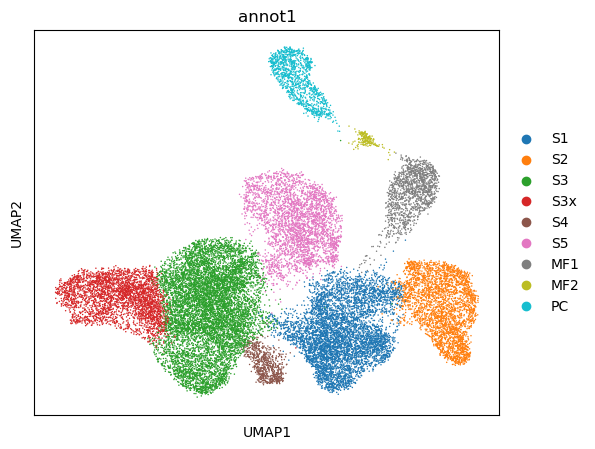

In [19]:
# Establish annot-color association consistent with other parts of manuscript
sc.pl.umap(rna_ad, color='annot1', palette='tab10')

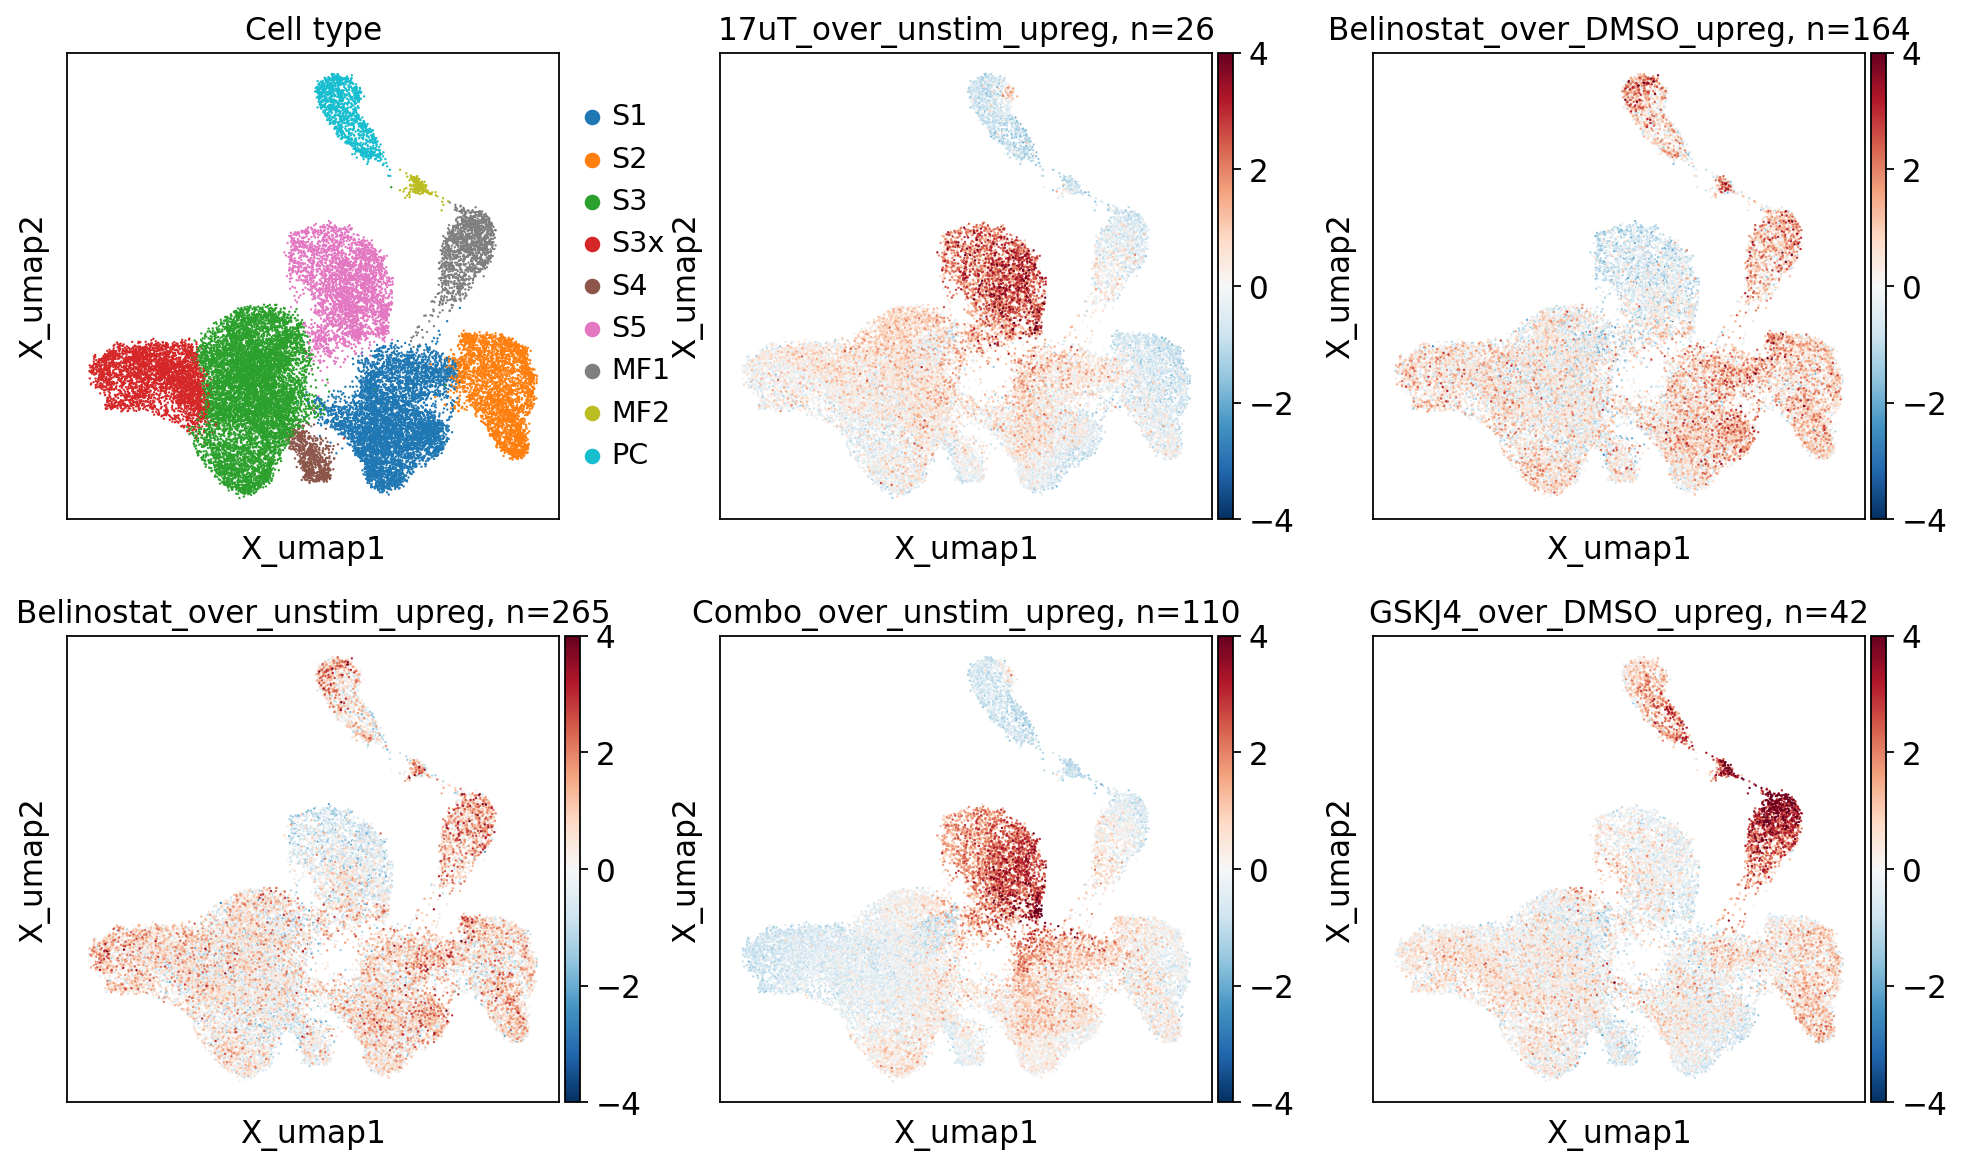

In [20]:
sk.set_figsize((3, 3))
sc.set_figure_params(dpi_save=300)
sc.pl.embedding(
    rna_ad,
    basis='X_umap',
    color=['annot1'] + [f'{rstim}_upreg_scaled' for rstim in de_tabs_sig.keys()],
    ncols=3,
    #cmap='viridis',
    cmap='RdBu_r',
    title=['Cell type'] + [f'{rstim}_upreg, n={de_tabs_sig[rstim].shape[0]}' for rstim in de_tabs_sig.keys()],
    vmin=-4, vmax=4,
    #vcenter=0,
    save="_bulkDE_signature_projection_scaled_batch2.pdf"
)

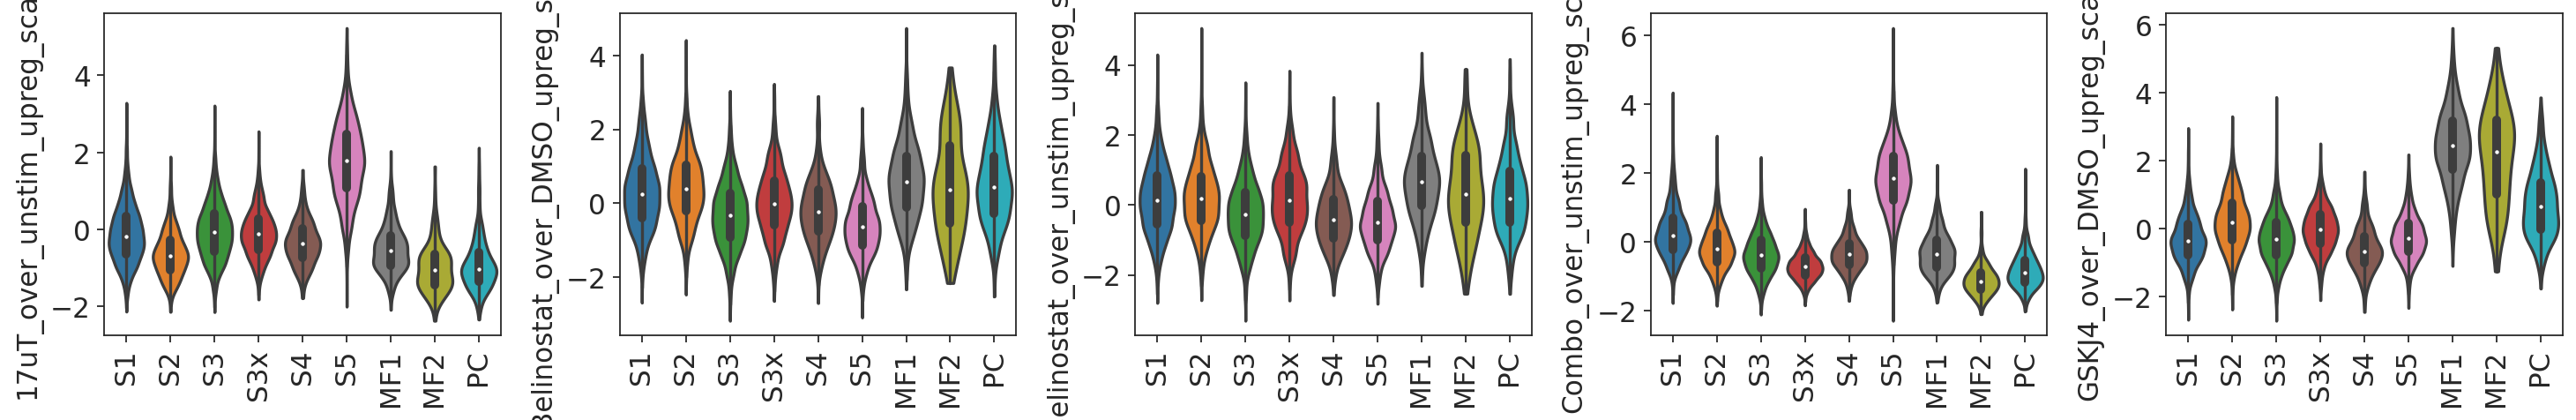

In [21]:
sk.set_figsize((4, 3))

sns.set_style("ticks")  # to prevent gridlines
sc.pl.violin(
    rna_ad,
    groupby='annot1',
    keys=[f'{rstim}_upreg_scaled' for rstim in de_tabs_sig.keys()],
    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_bulkDE_signature_projection_batch2_v2.pdf",
    grid=False
)


In [22]:
rna_ad

AnnData object with n_obs × n_vars = 26727 × 17590
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1', '17uT_over_unstim_upreg', 'Belinostat_over_DMSO_upreg', 'Belinostat_over_unstim_upreg', 'Combo_over_unstim_upreg', 'GSKJ4_over_DMSO_upreg', '17uT_over_unstim_upreg_scaled', 'Belinostat_over_DMSO_upreg_scaled', 'Belinostat_ove

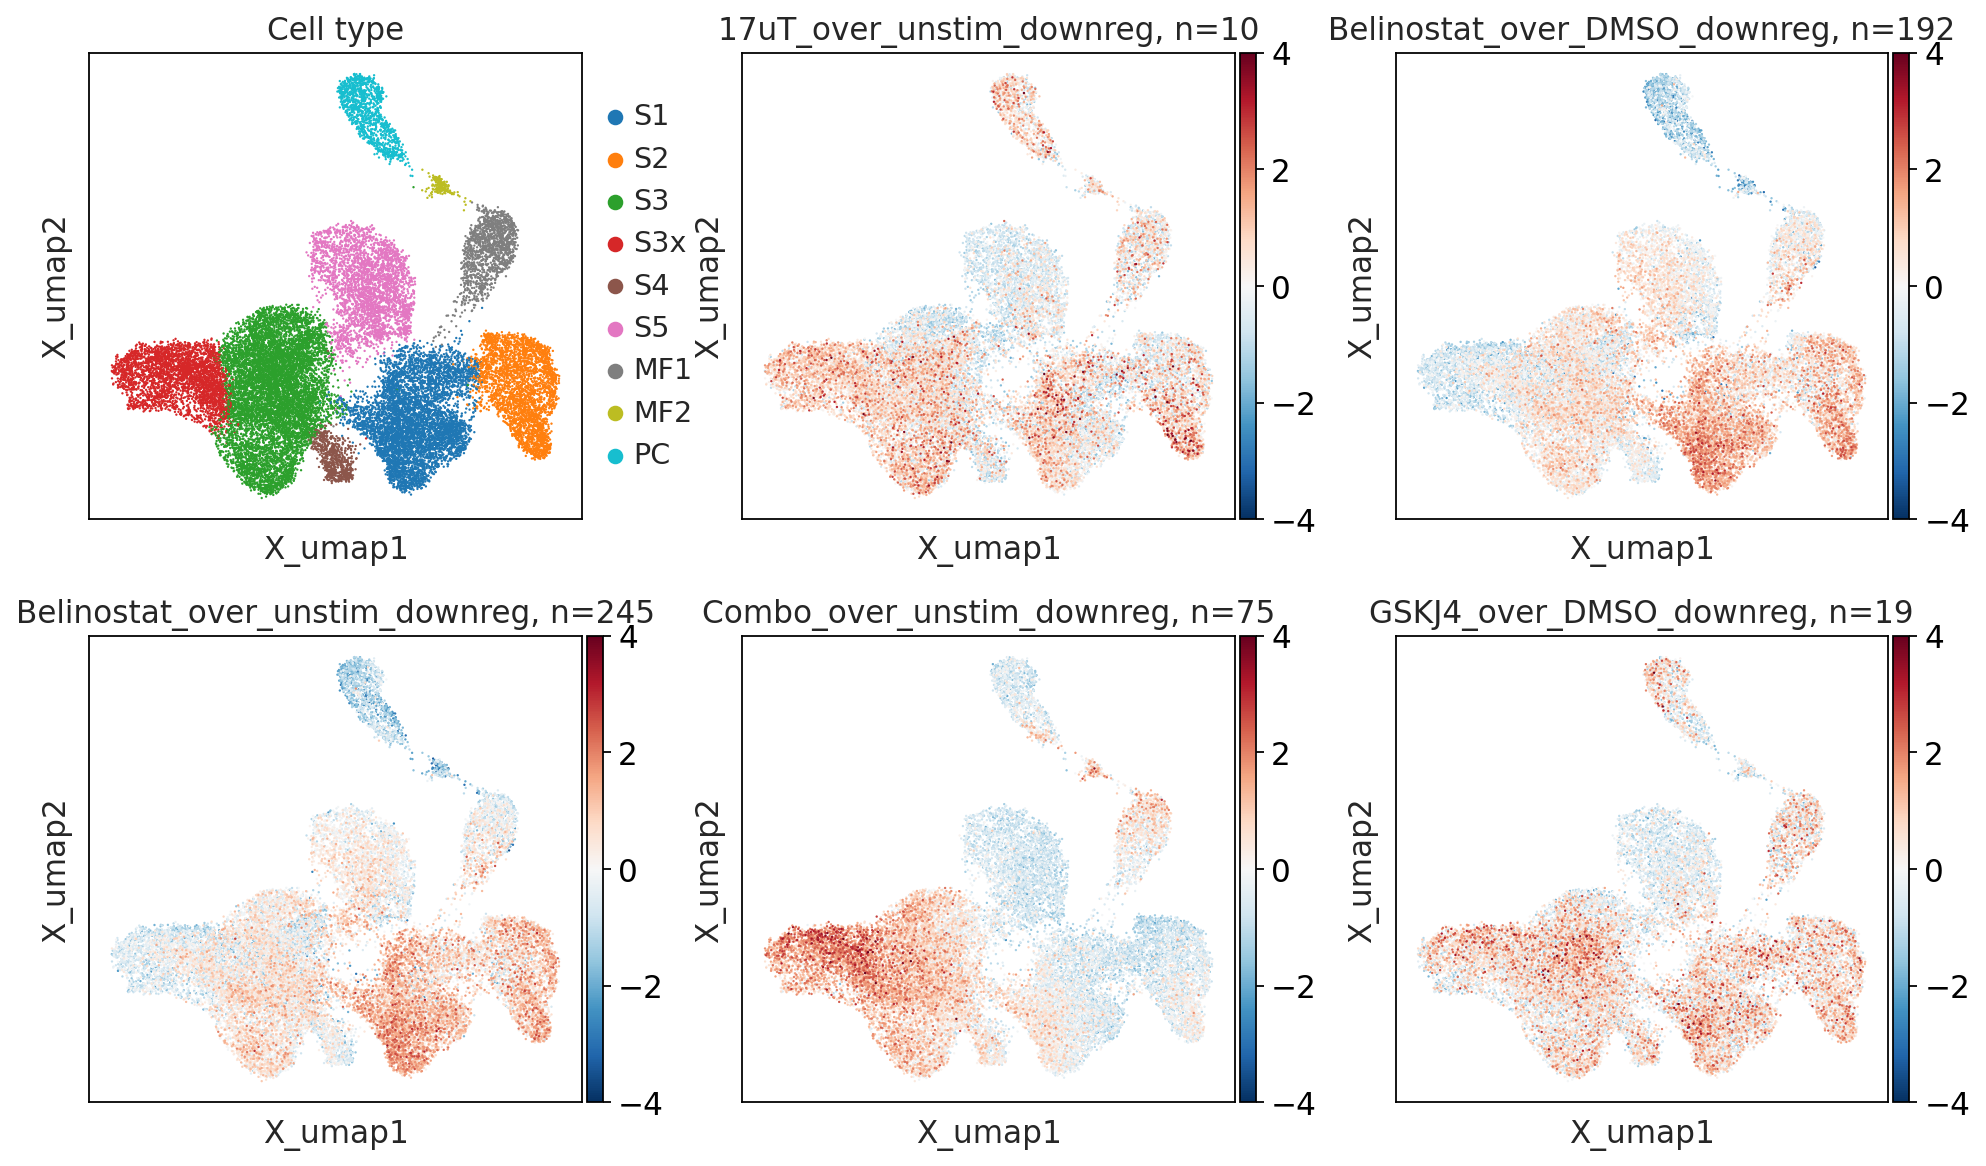

In [23]:
sk.set_figsize((3, 3))
sc.set_figure_params(dpi_save=300)

sc.pl.embedding(
    rna_ad,
    basis='X_umap',
    color=['annot1'] + [f'{rstim}_downreg_scaled' for rstim in de_tabs_sig_down.keys()],
    ncols=3,
    #cmap='viridis',
    cmap='RdBu_r',
    title=['Cell type'] + [f'{rstim}_downreg, n={de_tabs_sig_down[rstim].shape[0]}' for rstim in de_tabs_sig_down.keys()],
    vmin=-4, vmax=4,
    #vcenter=0,
    save="_bulkDE_signature_projection_scaled_down_batch2.pdf"
)

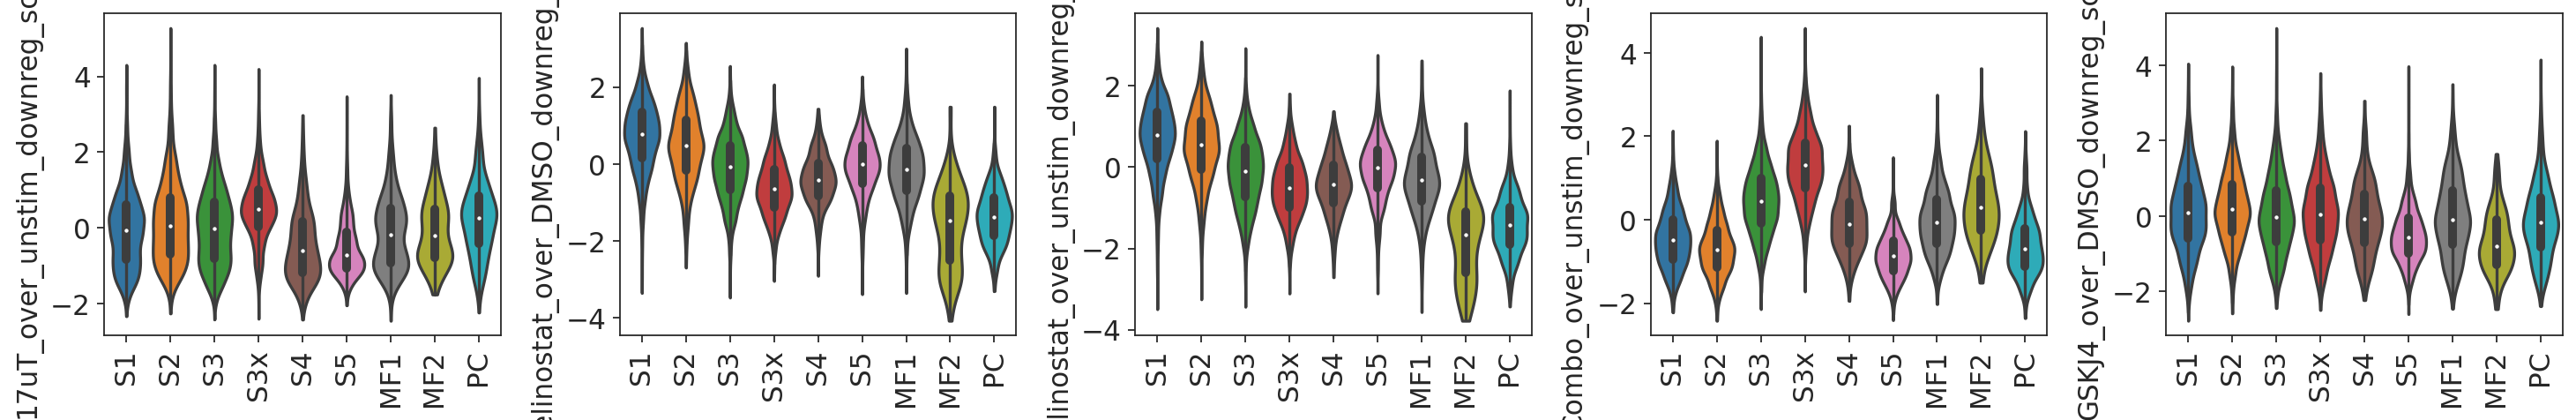

In [24]:
sk.set_figsize((4, 3))

sns.set_style("ticks")  # to prevent gridlines
sc.pl.violin(
    rna_ad,
    groupby='annot1',
    keys=[f'{rstim}_downreg_scaled' for rstim in de_tabs_sig.keys()],
    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_bulkDE_signature_projection_down_batch2_v2.pdf",
    grid=False
)